In [177]:
%load_ext autoreload
%autoreload 2

import numpy as np
import mne
import moabb
from moabb.datasets import BNCI2014_001
from moabb.paradigms import MotorImagery
from mne_connectivity import spectral_connectivity_epochs, phase_slope_index
import matplotlib.pyplot as plt
from matplotlib import colormaps
import warnings
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
paradigm = MotorImagery(n_classes=4)
mne.set_config("MNE_DATA", "/home/hice1/mchen439/scratch/mne_data")
mne.set_config("MNE_DATASETS_BNCI_PATH", "/home/hice1/mchen439/scratch/mne_data")
print(mne.get_config())

datasetMotorImagery = BNCI2014_001()
subjects = [1]
with warnings.catch_warnings(action="ignore"):
	X, y, metadata = paradigm.get_data(dataset=datasetMotorImagery, subjects=subjects)
	print(metadata.columns)
	print(np.unique(y))
	print(X.shape, y.shape, type(X), type(y), print(metadata.shape), print(type(metadata)))

Choosing from all possible events
/tmp/ipykernel_205827/768678516.py:3: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_PATH"
  mne.set_config("MNE_DATASETS_BNCI_PATH", "/home/hice1/mchen439/scratch/mne_data")


{'MNE_DATA': '/home/hice1/mchen439/scratch/mne_data', 'MNE_DATASETS_ALEXEEG_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_BNCI_PATH': '/home/hice1/mchen439/scratch/mne_data', 'MNE_DATASETS_EEGBCI_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_FAKEDATASET-IMAGERY-10-2--60-60--120-120--FAKE1-FAKE2-FAKE3--C3-CZ-C4_PATH': '/tmp/tmpwour6ucf', 'MNE_DATASETS_FAKEVIRTUALREALITYDATASET-P300-21-1--60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60--120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120--TARGET-NONTARGET--C3-CZ-C4_PATH': '/tmp/tmpvhx98uwa', 'MNE_DATASETS_GIGADB_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_LEE2019-MI_PATH': '/home/hice1/mchen439/mne

In [4]:
feet_indices = np.where(y == "feet")[0]
left_hand_indices = np.where(y == "left_hand")[0]
right_hand_indices = np.where(y == "right_hand")[0]
tongue_indices = np.where(y == "tongue")[0]
X_feet = X[feet_indices, :, :300]
X_left_hand = X[left_hand_indices, :, :300]
X_right_hand = X[right_hand_indices, :, :300]
X_tongue = X[tongue_indices, :, :300]

print(X_feet.shape, X_left_hand.shape, X_right_hand.shape, X_tongue.shape)


(144, 22, 300) (144, 22, 300) (144, 22, 300) (144, 22, 300)


In [54]:
def normalize(X):
	normalized = np.zeros(X.shape)
	for channel in range(X.shape[0]):
		normalized[channel] = X[channel] / np.max(np.abs(X[channel]))
	return normalized

def compute_vector_autoregression(X, conn, sfreq, lookback=5):
	X_avg = normalize(X.mean(axis=0))
	n_channels = X_avg.shape[0]
	generated = np.zeros((n_channels, X_avg.shape[1]))
	X_initial_state = X_avg[:, :lookback]
	generated[:, :lookback] = X_initial_state
	dt = 1 / sfreq
	for t in range(lookback, X_avg.shape[1]):
		for i in range(n_channels):
			# Forward Euler calculation
			# calculate dot_x_t_i
			epsilon_i = np.random.standard_normal() # Noise
			dxidt = 0
			for p in range(1, lookback): 
				for j in range(n_channels):
					dxidt += conn[i, j] * generated[j, t - p] + epsilon_i
			generated[i, t] = generated[i, t - 1] + dxidt * dt

	return generated

def make_directed_dpli(m):
	directed = np.zeros(m.shape)
	for sensor_1 in range(m.shape[0]):
		for sensor_2 in range(sensor_1):
			if m[sensor_1, sensor_2] <= 0.4:
				directed[sensor_1, sensor_2] = 2 * abs(m[sensor_1, sensor_2] - 0.5)
			elif m[sensor_1, sensor_2] >= 0.6:
				directed[sensor_2, sensor_1] = 2 * abs(m[sensor_1, sensor_2] - 0.5)
			else:
				directed[sensor_1, sensor_2] = 2 * abs(m[sensor_1, sensor_2] - 0.5)
				directed[sensor_2, sensor_1] = 2 * abs(m[sensor_1, sensor_2] - 0.5)
	return directed

In [47]:
def symmetrize(a):
	return a + a.T - np.diag(np.diag(a))

conn_feet_dpli = spectral_connectivity_epochs(
	X_feet,
	method="dpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False,
	n_jobs = 4
)

conn_left_hand_dpli = spectral_connectivity_epochs(
	X_left_hand,
	method="dpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False,
	n_jobs = 4
)

conn_right_hand_dpli = spectral_connectivity_epochs(
	X_right_hand,
	method="dpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False,
	n_jobs=4
)

conn_tongue_dpli = spectral_connectivity_epochs(
	X_tongue,
	method="dpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False,
	n_jobs=4
)

conn_feet_dpli_np = np.squeeze(conn_feet_dpli.get_data("dense"))
conn_left_hand_dpli_np = np.squeeze(conn_left_hand_dpli.get_data("dense"))
conn_right_hand_dpli_np = np.squeeze(conn_right_hand_dpli.get_data("dense"))
conn_tongue_dpli_np = np.squeeze(conn_tongue_dpli.get_data("dense"))

conn_feet_dpli_np_symm = symmetrize(conn_feet_dpli_np)
conn_left_hand_dpli_np_symm = symmetrize(conn_left_hand_dpli_np)
conn_right_hand_dpli_np_symm = symmetrize(conn_right_hand_dpli_np)
conn_tongue_dpli_np_symm = symmetrize(conn_tongue_dpli_np)


In [55]:
predicted_feet = compute_vector_autoregression(X_feet, make_directed_dpli(conn_feet_dpli_np_symm), 250, 5)
print(predicted_feet.shape)

(22, 300)


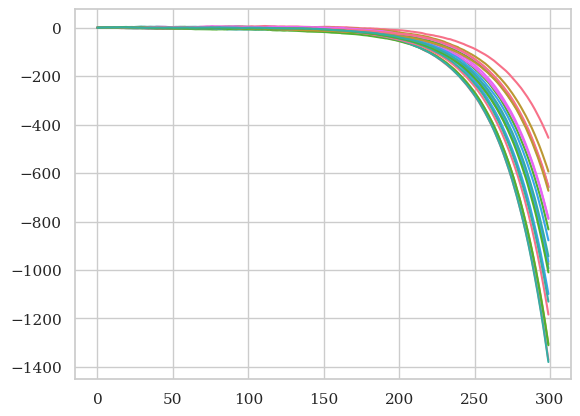

In [56]:
for ch in range(predicted_feet.shape[0]):
	plt.plot(predicted_feet[ch, 0:500])
plt.show()

In [57]:
psi_feet = phase_slope_index(
	X_feet,
	mode="multitaper",
	sfreq=250,
	fmin=8,
	fmax=30,
	verbose=False
)

psi_left_hand = phase_slope_index(
	X_left_hand,
	mode="multitaper",
	sfreq=250,
	fmin=8,
	fmax=30,
	verbose=False
)

psi_right_hand = phase_slope_index(
	X_right_hand,
	mode="multitaper",
	sfreq=250,
	fmin=8,
	fmax=30,
	verbose=False
)

psi_tongue = phase_slope_index(
	X_tongue,
	mode="multitaper",
	sfreq=250,
	fmin=8,
	fmax=30,
	verbose=False
)


In [58]:
def make_directed_psi(m):
	directed = np.zeros(m.shape)
	for sensor_1 in range(m.shape[0]):
		for sensor_2 in range(sensor_1):
			if m[sensor_1, sensor_2] <= 0:
				directed[sensor_1, sensor_2] = m[sensor_1, sensor_2]
			else:
				directed[sensor_2, sensor_1] = m[sensor_1, sensor_2]
	return directed

In [59]:
predicted_feet = compute_vector_autoregression(X_feet, make_directed_psi(psi_feet.get_data("dense")[:,:, 0]), 250, 5)
print(predicted_feet.shape)
print(predicted_feet)
print(np.count_nonzero(make_directed_psi(psi_feet.get_data("dense")[:,:, 0])))

(22, 300)
[[-0.37961674 -0.36374656 -0.25080598 ...  1.43063455  1.49465323
   1.88906335]
 [-0.2011181  -0.22941822 -0.19359386 ... -4.5099329  -3.93740845
  -3.35447885]
 [-0.15586826 -0.1729642  -0.13850038 ...  1.77909658  2.16365021
   2.40980546]
 ...
 [-0.29477471 -0.16959844 -0.03433756 ...  5.72863535  5.17809025
   5.14549269]
 [-0.29638404 -0.1305066   0.0495923  ... -1.52064022 -0.48833909
  -0.29801124]
 [-0.34835323 -0.19455095 -0.01550948 ... -2.66144874 -2.81433252
  -2.99317663]]
231


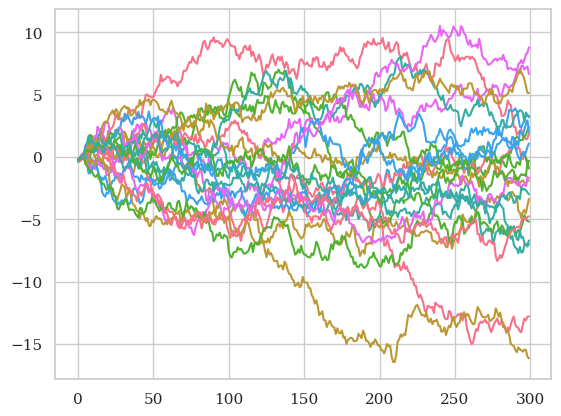

In [60]:
for ch in range(predicted_feet.shape[0]):
	plt.plot(predicted_feet[ch, 0:500])
plt.show()

In [173]:
def generate_bivariate(T, P, D):
	np.random.seed(0)
	z = np.zeros((D, T))
	z[:, :P] = np.random.standard_normal((D, P))
	m = np.zeros((D , D))
	m[np.tril_indices(m.shape[0])] = 1 / P
	np.fill_diagonal(m, 0)
	for t in range(P, T):
		for p in range(P):
			z[:, t] += m @ z[:, t - p] 
		z[:, t] += np.random.standard_normal(D)
	return z

400
(2, 100000)
(100000,)
(99750, 100000)


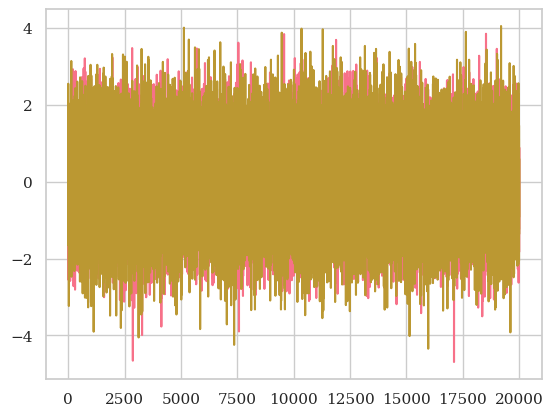

In [190]:
import ordpy
from ordpy import maximum_complexity_entropy, minimum_complexity_entropy
hc_min_curve = minimum_complexity_entropy(dx=5, dy=1, size=200).T
hc_max_curve = maximum_complexity_entropy(dx=5, dy=1, m=10).T
hmin, cmin = hc_min_curve  
hmax, cmax = hc_max_curve
T_max = 100000
window_size = 250
windows = []
for i in range(0, T_max, window_size):
	windows.append((i, i + window_size))


z = generate_bivariate(T = T_max, P = 5, D = 2)
xy_avg = (z[0] + z[1]) // 2
print(len(windows))
print(z.shape)
print(xy_avg.shape)
print(windows[-1])
plt.plot(z[0, ::5])
plt.plot(z[1, ::5])
plt.show()

In [191]:
low_sos = scipy.signal.butter(3, 32, 'low', output='sos', fs=250)
high_sos = scipy.signal.butter(3, 8, 'high', output='sos', fs=250)


z[0] = scipy.signal.sosfilt(high_sos, scipy.signal.sosfilt(low_sos, z[0]))
z[1] = scipy.signal.sosfilt(high_sos, scipy.signal.sosfilt(low_sos, z[1]))

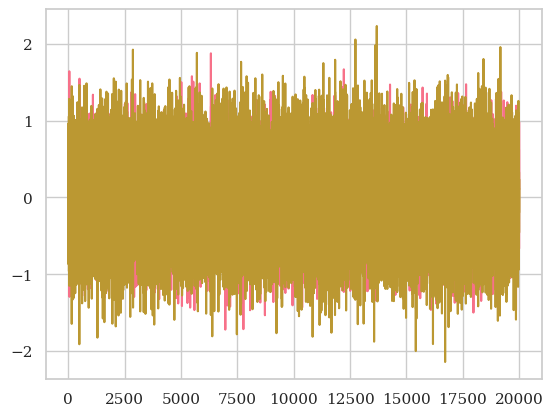

In [192]:
plt.plot(z[0, ::5])
plt.plot(z[1, ::5])

/tmp/ipykernel_170984/866817444.py:26: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend((upper, lower, x_linear_plot, y_linear_plot, xy_avg_linear_plot), ("Maximum Complexity Entropy", "Minimum Complexity Entropy", "X", "Y", "X, Y Average"), scatterpoints=1)


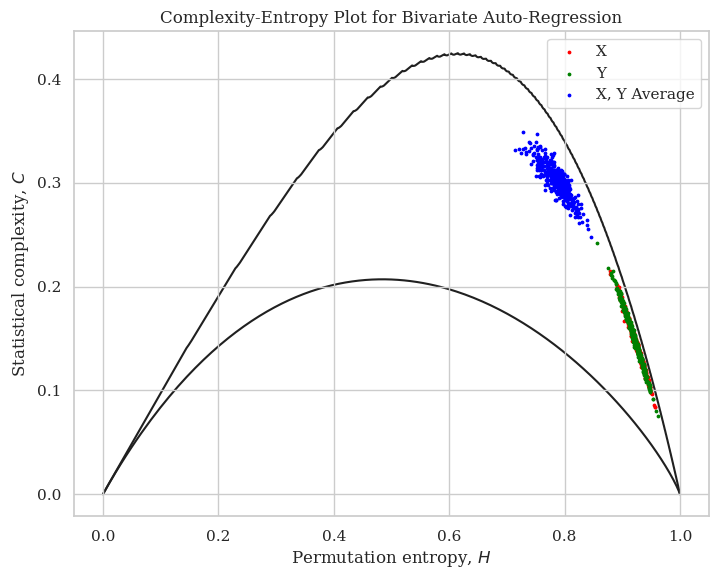

In [204]:
f, ax = plt.subplots(figsize=(8.19, 6.3))
hc_linear_x = np.zeros((len(windows), 2))
hc_linear_y = np.zeros((len(windows), 2))
hc_linear_xy_avg = np.zeros((len(windows), 2))
for idx, (start_idx, end_idx) in enumerate(windows):
	x_entropy, x_complexity = ordpy.complexity_entropy(data=z[0, start_idx:end_idx], dx=int(5), dy=int(1), taux=int(3), tauy=int(1))
	hc_linear_x[idx][0] = x_entropy
	hc_linear_x[idx][1] = x_complexity

	y_entropy, y_complexity = ordpy.complexity_entropy(data=z[1, start_idx:end_idx], dx=int(5), dy=int(1), taux=int(3), tauy=int(1))
	hc_linear_y[idx][0] = y_entropy
	hc_linear_y[idx][1] = y_complexity

	xy_entropy, xy_complexity = ordpy.complexity_entropy(data=xy_avg[start_idx:end_idx], dx=int(5), dy=int(1), taux=int(3), tauy=int(1))
	hc_linear_xy_avg[idx][0] = xy_entropy
	hc_linear_xy_avg[idx][1] = xy_complexity

upper = ax.plot(hmin, cmin, linewidth=1.5, color='#202020', zorder=0)
lower = ax.plot(hmax, cmax, linewidth=1.5, color='#202020', zorder=0)
x_linear_plot = ax.scatter(hc_linear_x[:,0], hc_linear_x[:,1], c="r", s=3)
y_linear_plot = ax.scatter(hc_linear_y[:,0], hc_linear_y[:,1], c="g", s=3)
xy_avg_linear_plot = ax.scatter(hc_linear_xy_avg[:,0], hc_linear_xy_avg[:,1], c="b", s=3)
ax.set_title("Complexity-Entropy Plot for Bivariate Auto-Regression")
ax.set_ylabel('Statistical complexity, $C$')
ax.set_xlabel('Permutation entropy, $H$')
ax.legend((upper, lower, x_linear_plot, y_linear_plot, xy_avg_linear_plot), ("Maximum Complexity Entropy", "Minimum Complexity Entropy", "X", "Y", "X, Y Average"), scatterpoints=1)
plt.show()

In [171]:
x_entropy, x_complexity = ordpy.complexity_entropy(data=np.ones(1000), dx=int(5), dy=int(1), taux=int(3), tauy=int(1))
print(x_entropy, x_complexity)

-0.0 -0.0


In [201]:
Z = z.reshape(1, z.shape[0], 100000)

In [202]:
conn = spectral_connectivity_epochs(
	Z,
	method="dpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=32,
	faverage=True,
	verbose=False,
	n_jobs=4
)

In [203]:
print(conn.get_data("dense"))

[[[0.        ]
  [0.        ]]

 [[0.02864285]
  [0.        ]]]
